# Notebook for testing flux limits

### Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

file = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN.csv')
df = pd.DataFrame(file) # 30,911 galaxies
df = df[df['Use'] == 1] # 13,299 galaxies
df = df[df['LIR'] > 0] # 8,486

z_bins = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]
percentiles = [20, 20, 30, 30, 30, 30] # percentiles for each redshift bin

### Bolometric Luminosity vs Redshift

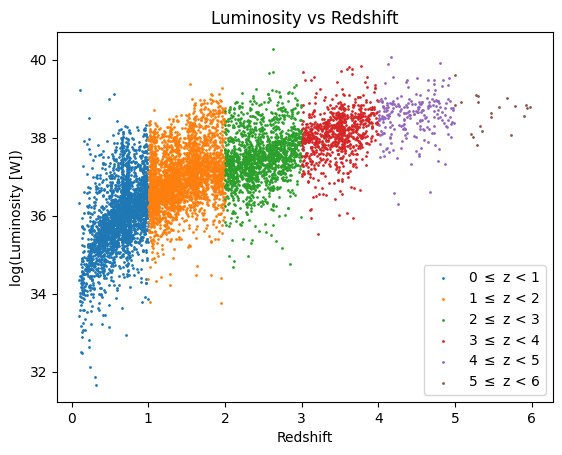

In [2]:
z = df['zpk'].values # redshift

lum = df['LIR'].copy().values # solar luminosity
lum *= 3.828 * 10 ** 26 # solar luminosity -> Watts

for z_start, z_end in z_bins:
    mask_z = (z >= z_start) & (z < z_end)
    plt.scatter(z[mask_z], np.log10(lum[mask_z]), s=1, label=f'{z_start} $\leq$ z < {z_end}')
plt.title('Luminosity vs Redshift')
plt.xlabel('Redshift')
plt.ylabel('log(Luminosity [W])')
plt.legend()
plt.show()

### Bolometric Flux

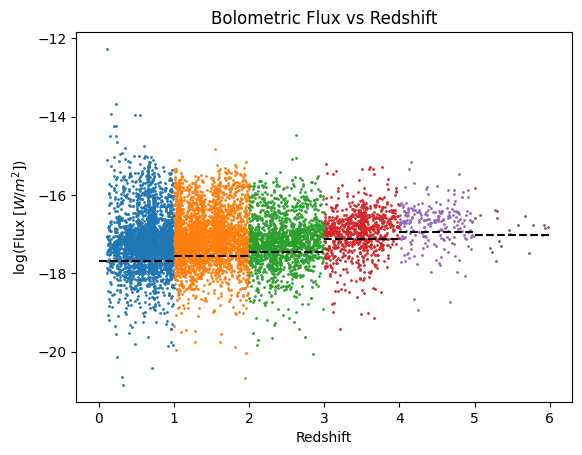

In [3]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
d_L = cosmo.luminosity_distance(z).to(u.m).value # m

F_bol = lum / (4 * np.pi * d_L ** 2) # W/m^2

F_lims = []
for (z_start, z_end), per in zip(z_bins, percentiles):
    mask_z = (z >= z_start) & (z < z_end)
    plt.scatter(z[mask_z], np.log10(F_bol[mask_z]), s=1, label=f'{z_start} $\leq$ z < {z_end}')
    p = np.percentile(F_bol[mask_z], per) # 80% of the data is above this value
    plt.hlines(np.log10(p), color='k', linestyle='--', label='Flux limit', xmin=z_start, xmax=z_end)
    F_lims.append(p)
plt.title('Bolometric Flux vs Redshift')
plt.ylabel('log(Flux [$W/m^2$])')
plt.xlabel('Redshift')
plt.show()

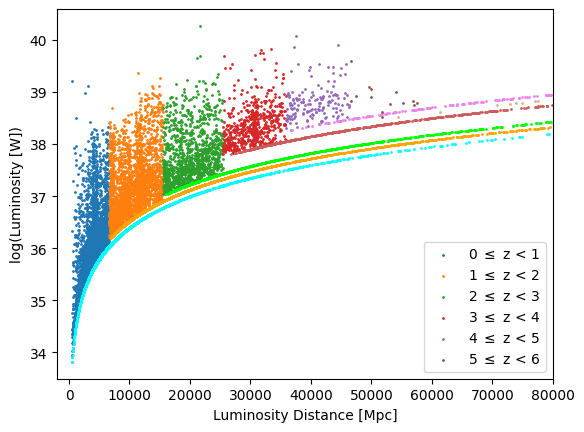

In [4]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
d_L = cosmo.luminosity_distance(z).value # Mpc
colours = ['cyan', 'orange', 'lime', 'indianred', 'violet', 'tan']

for (z_start, z_end), F_lim, c in zip(z_bins, F_lims, colours):
    mask_z = (z >= z_start) & (z < z_end)
    mask_flux = F_bol > F_lim
    plt.scatter(d_L[mask_z & mask_flux], np.log10(lum[mask_z & mask_flux]), s=1, label=f'{z_start} $\leq$ z < {z_end}')
    
    dmax = np.sqrt(lum[mask_z & mask_flux] / (4 * np.pi * F_lim)) # sqrt(W / W/m^2) = sqrt(m^2) = m
    dmax *= 3.241 * 10 **-23
    plt.scatter(dmax, np.log10(lum[mask_z & mask_flux]), s=1, color=c)
plt.ylabel('log(Luminosity [W])')
plt.xlabel('Luminosity Distance [Mpc]')
plt.xlim(-2000, 80000)
plt.legend()
plt.show()

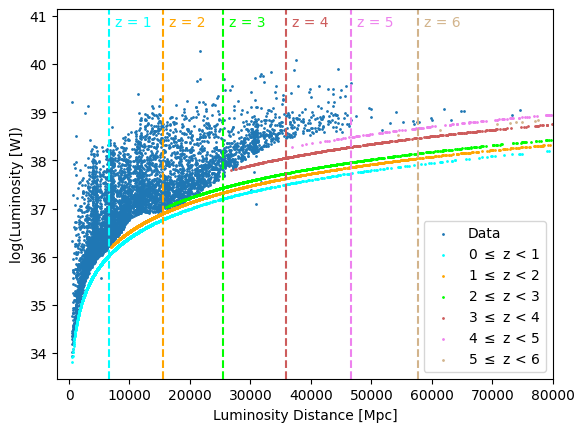

In [5]:
Flim = 0.003 # mJy
mask_f = df['F24'] > Flim

lum_new = df['LIR'].copy().values # solar luminosity
lum_new *= 3.828 * 10 ** 26 # solar luminosity -> Watts

plt.scatter(d_L[mask_f], np.log10(lum_new[mask_f]), s=1, label='Data')

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
d_L = cosmo.luminosity_distance(z).value # Mpc
colours = ['cyan', 'orange', 'lime', 'indianred', 'violet', 'tan']

for (z_start, z_end), F_lim, c in zip(z_bins, F_lims, colours):
    mask_z = (z >= z_start) & (z < z_end)
    mask_flux = F_bol > F_lim
    
    dmax = np.sqrt(lum[mask_z & mask_flux] / (4 * np.pi * F_lim)) # sqrt(W / W/m^2) = sqrt(m^2) = m
    dmax *= 3.241 * 10 **-23
    
    plt.scatter(dmax, np.log10(lum[mask_z & mask_flux]), s=1, color=c, label=f'{z_start} $\leq$ z < {z_end}')
    plt.axvline(cosmo.luminosity_distance(z_end).value, color=c, linestyle='--')
    plt.text(cosmo.luminosity_distance(z_end).value+1e3, max(np.log10(lum)), f'z = {z_end}', color=c)
plt.ylabel('log(Luminosity [W])')
plt.xlabel('Luminosity Distance [Mpc]')
plt.xlim(-2000, 80000)
plt.legend()
plt.show()